In [2]:
import numpy as np
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from scipy.spatial import cKDTree
import xarray as xr
import cartopy.crs as ccrs

In [3]:
def read_mesh_coordinates(mesh_path):
    """
    Read ADCIRC mesh coordinates from fort.14 file
    
    Parameters:
    mesh_path: Path to the fort.14 file
    
    Returns:
    mesh_points: Numpy array with shape (n_nodes, 2) containing x, y coordinates
    """
    mesh_points = []
    
    with open(mesh_path, 'r') as f:
        # Read header line (ignored)
        f.readline()
        
        # Read number of elements and nodes
        line = f.readline().split()
        num_elements = int(line[0])
        num_nodes = int(line[1])
        
        # Read nodal coordinates
        for i in range(num_nodes):
            line = f.readline().split()
            node_id = int(line[0])
            x = float(line[1])
            y = float(line[2])
            # z = float(line[3])  # Not needed for this function
            
            mesh_points.append([x, y])
    
    return np.array(mesh_points)

In [4]:
def expand_flooding_hand_realistic(adcirc_output, dem_path, mesh_path):
    import xarray as xr
    import rasterio
    from scipy.spatial import cKDTree
    
    # Read data
    adcirc_data = xr.open_dataset(adcirc_output)
    water_elevation = adcirc_data['zeta'].max(dim='time')
    
    with rasterio.open(dem_path) as dem:
        elevation = dem.read(1)
        transform = dem.transform
        crs = dem.crs
    
    # Read mesh points
    mesh_points = read_mesh_coordinates(mesh_path)
    
    # Clean data
    valid_mask = ~np.isnan(water_elevation)
    mesh_points_clean = mesh_points[valid_mask]
    water_elev_clean = water_elevation.values[valid_mask]
    
    # Get DEM grid coordinates
    rows, cols = np.indices(elevation.shape)
    x, y = rasterio.transform.xy(transform, rows.ravel(), cols.ravel())
    grid_coords = np.column_stack([x, y])
    
    # IDW interpolation
    tree = cKDTree(mesh_points_clean)
    
    # Find nearest neighbors with distance limit
    distances, indices = tree.query(grid_coords, k=5, distance_upper_bound=2000)
    
    # Initialize result
    water_elev_grid = np.zeros(len(grid_coords))
    
    for i in range(len(grid_coords)):
        # Get valid distances/indices (not inf)
        valid = distances[i] < np.inf
        if np.sum(valid) > 0:
            d = distances[i][valid]
            idx = indices[i][valid]
            
            # IDW with adaptive power based on mesh resolution
            power = 1.5  # Good balance for ADCIRC meshes
            weights = 1.0 / d**power
            weights /= weights.sum()
            
            water_elev_grid[i] = np.sum(weights * water_elev_clean[idx])
        else:
            # No nearby points - use global average as fallback
            water_elev_grid[i] = np.mean(water_elev_clean)
    
    # Reshape and calculate inundation
    water_elev_grid = water_elev_grid.reshape(elevation.shape)
    inundation_depth = np.maximum(0, water_elev_grid - elevation)
    
    # Handle DEM NaNs
    inundation_depth[np.isnan(elevation)] = np.nan
    
    return inundation_depth, transform, crs

In [5]:
output = "../sims/Gonave_SLR_mangrove/SSP1_2050/hotstart/fort.63.nc"
mesh_path = "../sims/Gonave_SLR_mangrove/S0/fort.14"
dempath = "../datasets/rasters/GrandPierre_fix.tif"

inundation_depth, transform, crs = expand_flooding_hand_realistic(output, dempath, mesh_path)

In [22]:
inundation_depth

array([[ 9999.49587264,  9999.49597971,  9999.49608061, ...,
        10000.11693272, 10000.11693269, 10000.11693266],
       [ 9999.49604357,  9999.49615127,  9999.49625263, ...,
        10000.11693512, 10000.11693509, 10000.11693505],
       [ 9999.49621152,  9999.49631988,  9999.49642176, ...,
        10000.11693753, 10000.11693749, 10000.11693744],
       ...,
       [ 9999.62980145,  9999.63002406,  9999.63024411, ...,
        10000.07013322, 10000.07013313, 10000.07013303],
       [ 9999.6298475 ,  9999.63007025,  9999.63029048, ...,
        10000.07013381, 10000.07013372, 10000.07013363],
       [ 9999.62989131,  9999.63011423,  9999.63033465, ...,
        10000.07013441, 10000.07013432, 10000.07013423]])

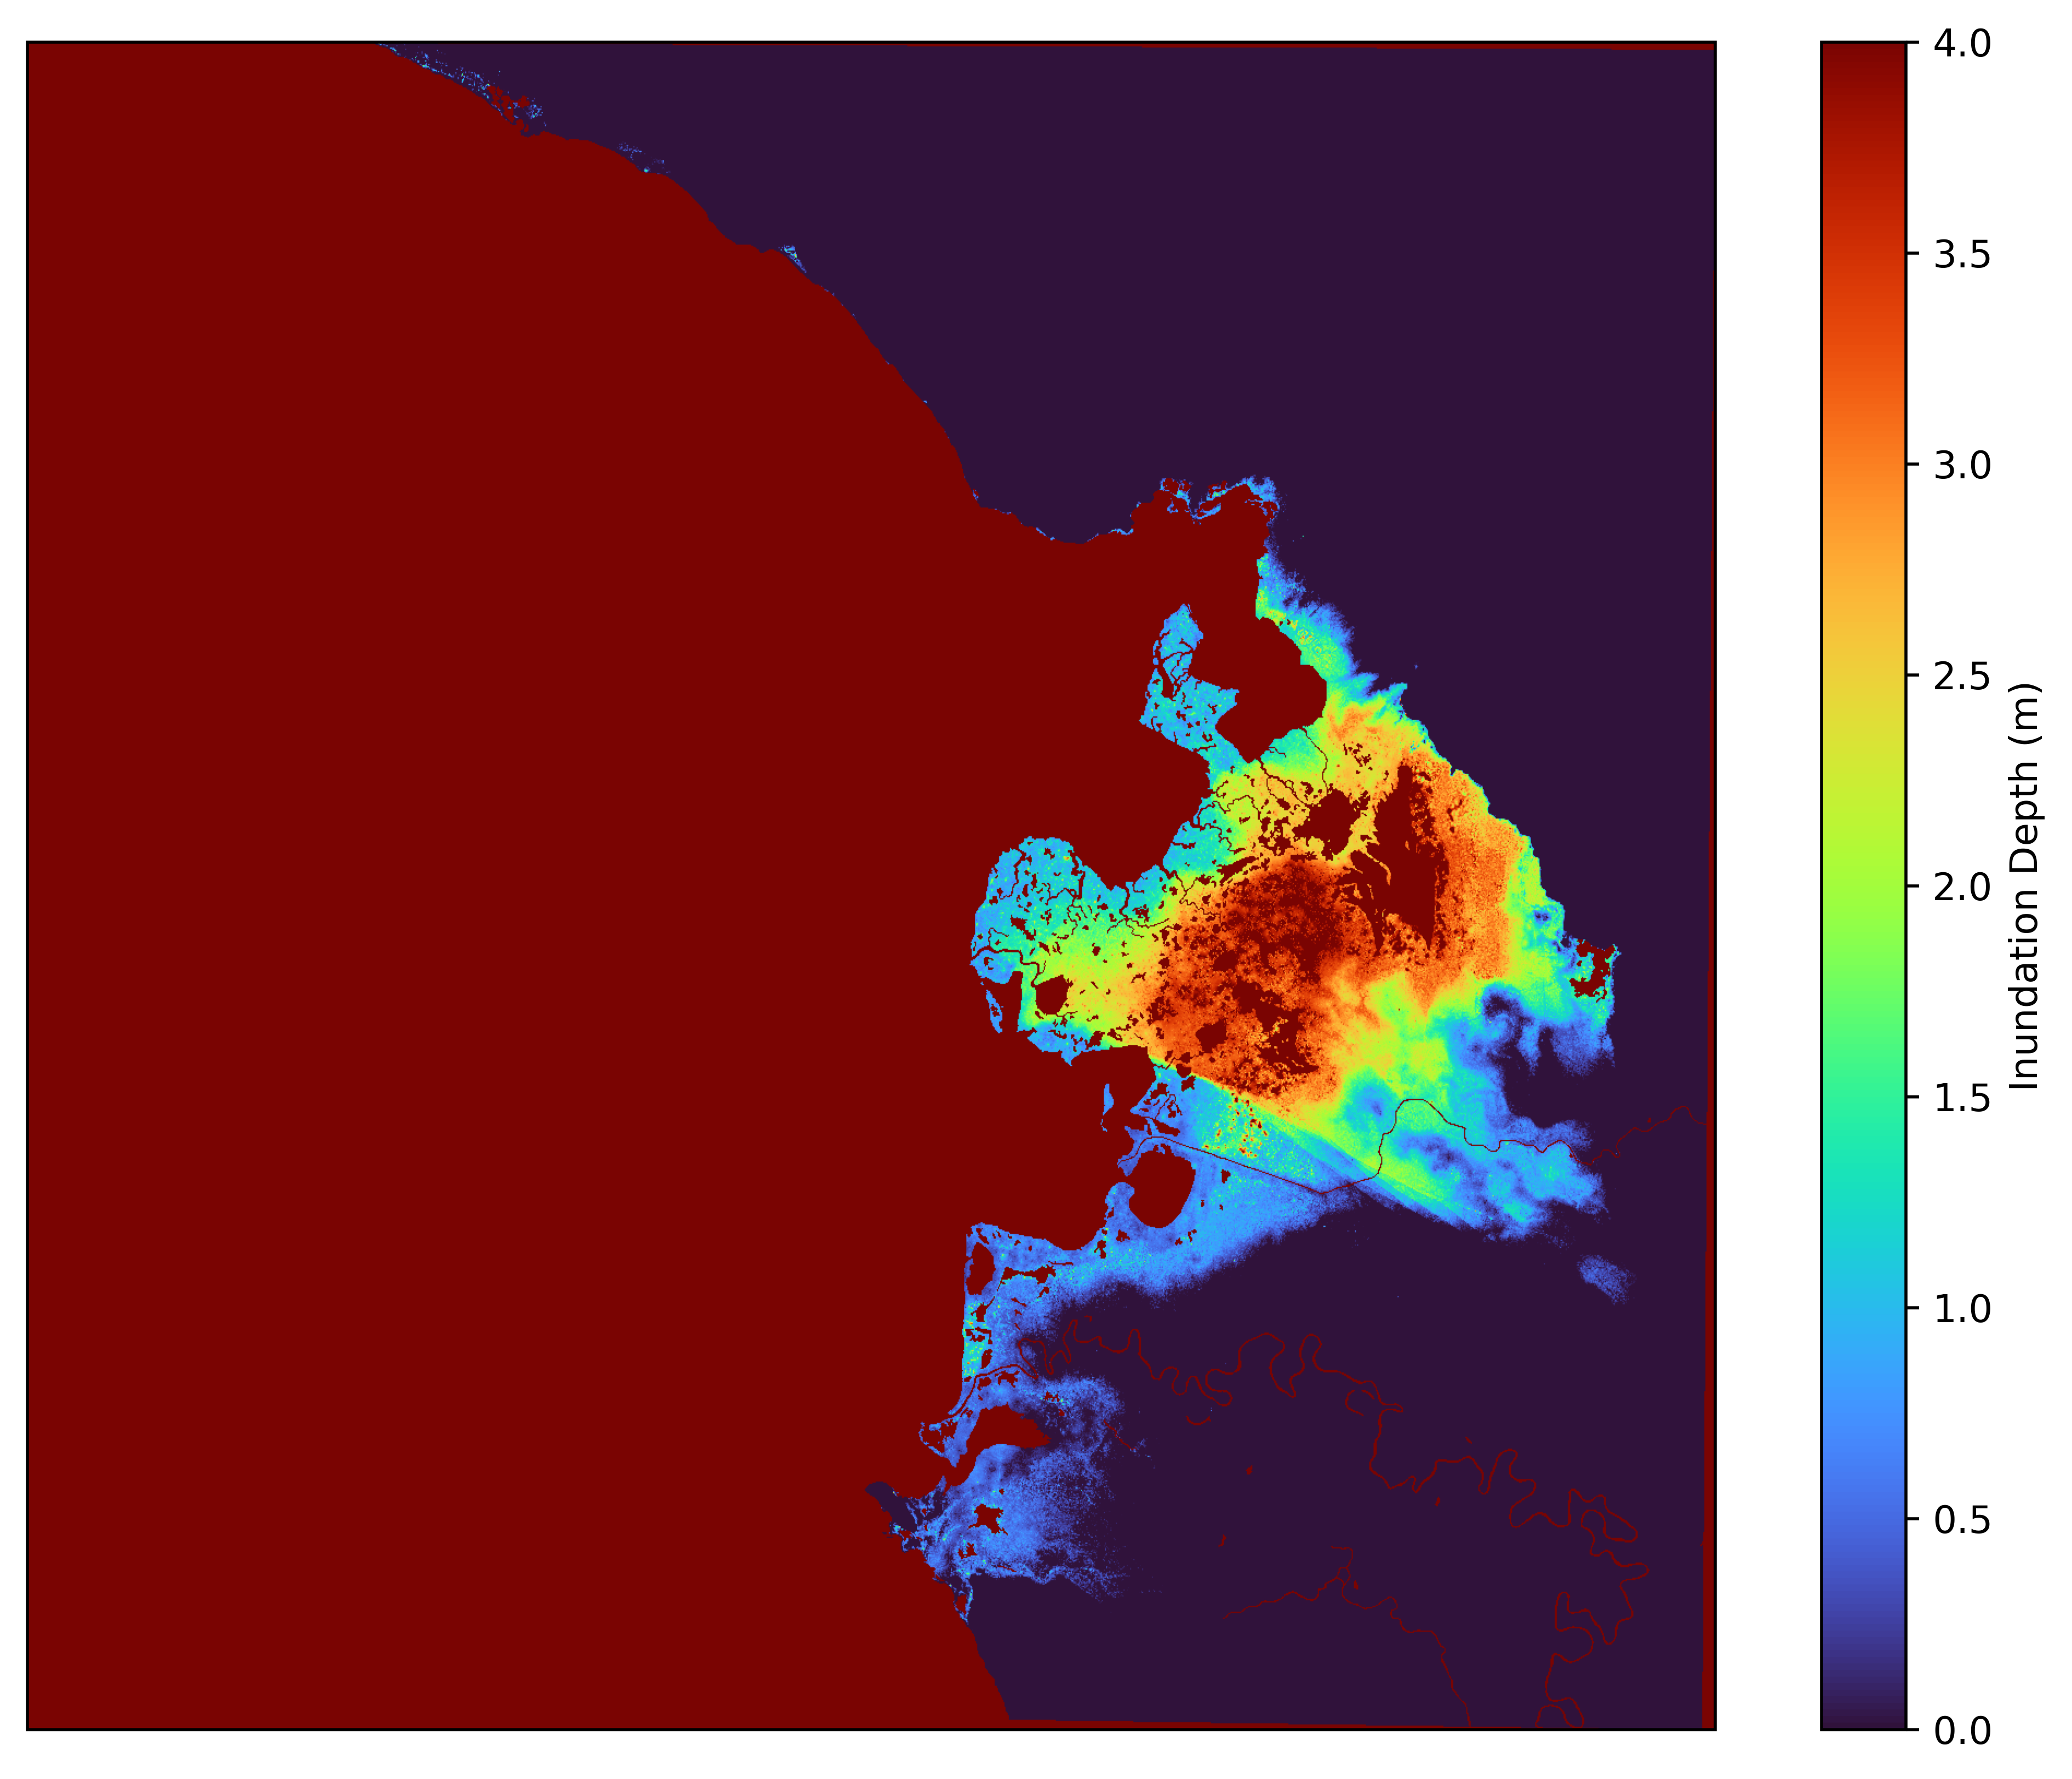

In [ ]:
extent = [-72.85, -72.6, 19.25, 19.5]
fig, ax = plt.subplots(figsize = (10,8), dpi=500, subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(inundation_depth, extent=extent, aspect=ax.get_aspect(), transform=ax.transAxes, cmap='turbo', vmin=0., vmax=4)


plt.colorbar(im, ax=ax, orientation='vertical', label='Inundation Depth (m)')

ax.set_extent(extent)

ax.top_labels = False
ax.right_labels = False
ax.xlocator = mpl.ticker.MaxNLocator(nbins=5)
ax.ylocator = mpl.ticker.MaxNLocator(nbins=5)